# Forecasting time series with missing values

In many real use cases of forecasting, although historical data are available, it is common for the time series to be incomplete. The presence of missing values in the data is a major problem since most forecasting algorithms require the time series to be complete in order to train a model.

A commonly employed strategy to overcome this problem is to impute missing values before training the model, for example, using a moving average. However, the quality of the imputations may not be good, impairing the training of the model. One way to improve the imputation strategy is to combine it with [weighted time series forecasting](https://skforecast.org/latest/user_guides/weighted-time-series-forecasting.html). The latter consists of reducing the weight of the imputed observations and thus their influence during model training.

 This document shows two examples of how **skforecast** makes it easy to apply this strategy.

## Libraries

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12,
    'lines.linewidth': 1.5
}
plt.rcParams.update(dark_style)

from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; padding-left: 10px;">

<p class="title">
    <i class="fa-light fa-pencil fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

In this document, a forecaster of type <code>ForecasterAutoreg</code> is used. The same strategy can be applied with any forecaster from skforecast.

</div>

## Data

In [2]:
# Data download
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/'
    'Estadistica-machine-learning-python/master/data/usuarios_diarios_bicimad.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y-%m-%d')
data = data[['fecha', 'Usos bicis total día']]
data.columns = ['date', 'users']
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data.head(3)

,users
date,
2014-06-23,99
2014-06-24,72
2014-06-25,119


In [3]:
# Generating gaps with missing values
# ==============================================================================
gaps = [
    ['2020-09-01', '2020-10-10'],
    ['2020-11-08', '2020-12-15'],
]

for gap in gaps:
    data.loc[gap[0]:gap[1]] = np.nan

In [4]:
# Split data into train-test
# ==============================================================================
data = data.loc['2020-06-01': '2021-06-01']
end_train = '2021-03-01'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(f"Dates train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train : 2020-06-01 00:00:00 --- 2021-03-01 00:00:00  (n=274)
Dates test  : 2021-03-01 00:00:00 --- 2021-06-01 00:00:00  (n=93)


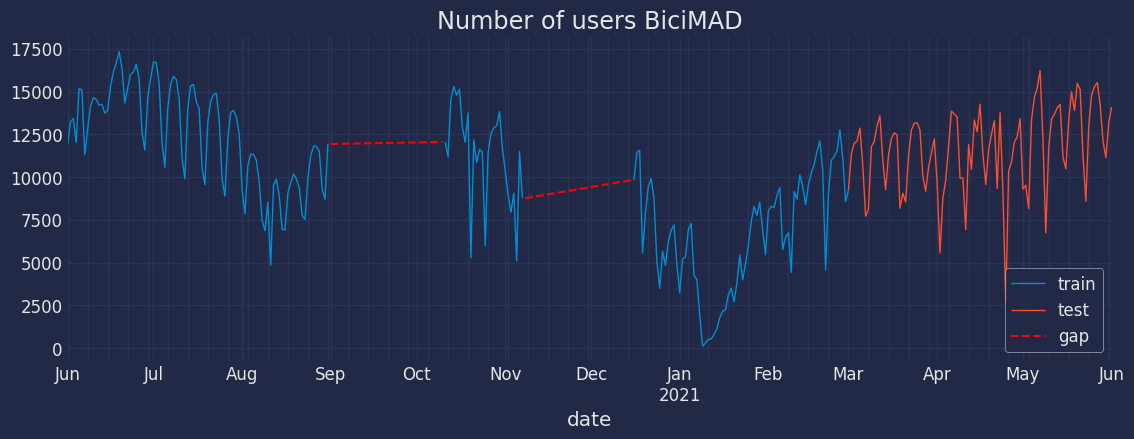

In [5]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
data_train.users.plot(ax=ax, label='train', linewidth=1)
data_test.users.plot(ax=ax, label='test', linewidth=1)

for gap in gaps:
    ax.plot(
        [pd.to_datetime(gap[0]), pd.to_datetime(gap[1])],
        [data.users[pd.to_datetime(gap[0]) - pd.Timedelta(days=1)],
         data.users[pd.to_datetime(gap[1]) + pd.Timedelta(days=1)]],
        color = 'red',
        linestyle = '--',
        label = 'gap'
        )

ax.set_title('Number of users BiciMAD')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower right');

## Impute missing values


In [6]:
# Value imputation using linear interpolation
# ======================================================================================
data['users_imputed'] = data['users'].interpolate(method='linear')
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

## Give weight of zero to imputed values

To minimize the influence on the model of imputed values, a custom function is defined to create weights following the rules:

+ Weight of 0 if the index date has been imputed or is within 14 days ahead of an imputed day.

+ Weight of 1 otherwise.

If an observation has a weight of 0, it has no influence at all during model training.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; padding-left: 10px;">

<p class="title">
    <i class="fa-circle-exclamation fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>


Imputed values should neither participate in the training process as a target nor as a predictor (lag). Therefore, values within a window size as large as the lags used should also be excluded.

</div>

In [7]:
# Custom function to create weights
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is in any gap.
    """
    gaps = [
        ['2020-09-01', '2020-10-10'],
        ['2020-11-08', '2020-12-15'],
    ]
    
    missing_dates = [pd.date_range(
                        start = pd.to_datetime(gap[0]) + pd.Timedelta('14d'),
                        end   = pd.to_datetime(gap[1]) + pd.Timedelta('14d'),
                        freq  = 'D'
                    ) for gap in gaps]
    missing_dates = pd.DatetimeIndex(np.concatenate(missing_dates))   
    weights = np.where(index.isin(missing_dates), 0, 1)

    return weights

`ForecasterAutoreg` is trained including the `custom_weights` function.

In [8]:
# Create a recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor   = LGBMRegressor(random_state=123),
                 lags        = 14,
                 weight_func = custom_weights
             )

# Backtesting: predict the next 7 days at a time.
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data.users_imputed,
                            initial_train_size = len(data.loc[:end_train]),
                            fixed_train_size   = False,
                            steps              = 7,
                            metric             = 'mean_absolute_error',
                            refit              = True,
                            verbose            = False
                        )
print(f"Backtesting metric (mean_absolute_error): {metric:.2f}")
predictions.head(4)

100%|██████████| 14/14 [00:00<00:00, 26.19it/s]

Backtesting metric (mean_absolute_error): 1904.83


,pred
2021-03-02,10524.159747
2021-03-03,10087.283682
2021-03-04,8882.926166
2021-03-05,9474.810215


In [9]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>